# Apple Stock LSTM Prediction Model

Import needed Libraries:

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

Import dataset:

In [40]:
df=pd.read_csv("HistoricalData_DecNasdaq.csv")
df.head()

,Date,Close,Volume,Open,High,Low
0,12/16/2022,$134.51,160156900,$136.685,$137.65,$133.73
1,12/15/2022,$136.5,98931910,$141.11,$141.8,$136.025
2,12/14/2022,$143.21,82291180,$145.35,$146.655,$141.16
3,12/13/2022,$145.47,93886160,$149.5,$149.9692,$144.24
4,12/12/2022,$144.49,70462650,$142.7,$144.5,$141.06


Substract Date and close columns:

In [41]:
df = df[['Date', 'Close']]
df.head()

,Date,Close
0,12/16/2022,$134.51
1,12/15/2022,$136.5
2,12/14/2022,$143.21
3,12/13/2022,$145.47
4,12/12/2022,$144.49


Remove “$” sign:

In [42]:
df = df.replace({'\$':''}, regex = True)

Convert closing price datatype to float and date to datetime:

In [43]:
df = df.astype({"Close": float})
df["Date"] = pd.to_datetime(df.Date, format="%m/%d/%Y")
df.dtypes

Date     datetime64[ns]
Close           float64
dtype: object

Definde date as index for visualization:

In [44]:
df.index = df['Date']

Construct the initial line chart:

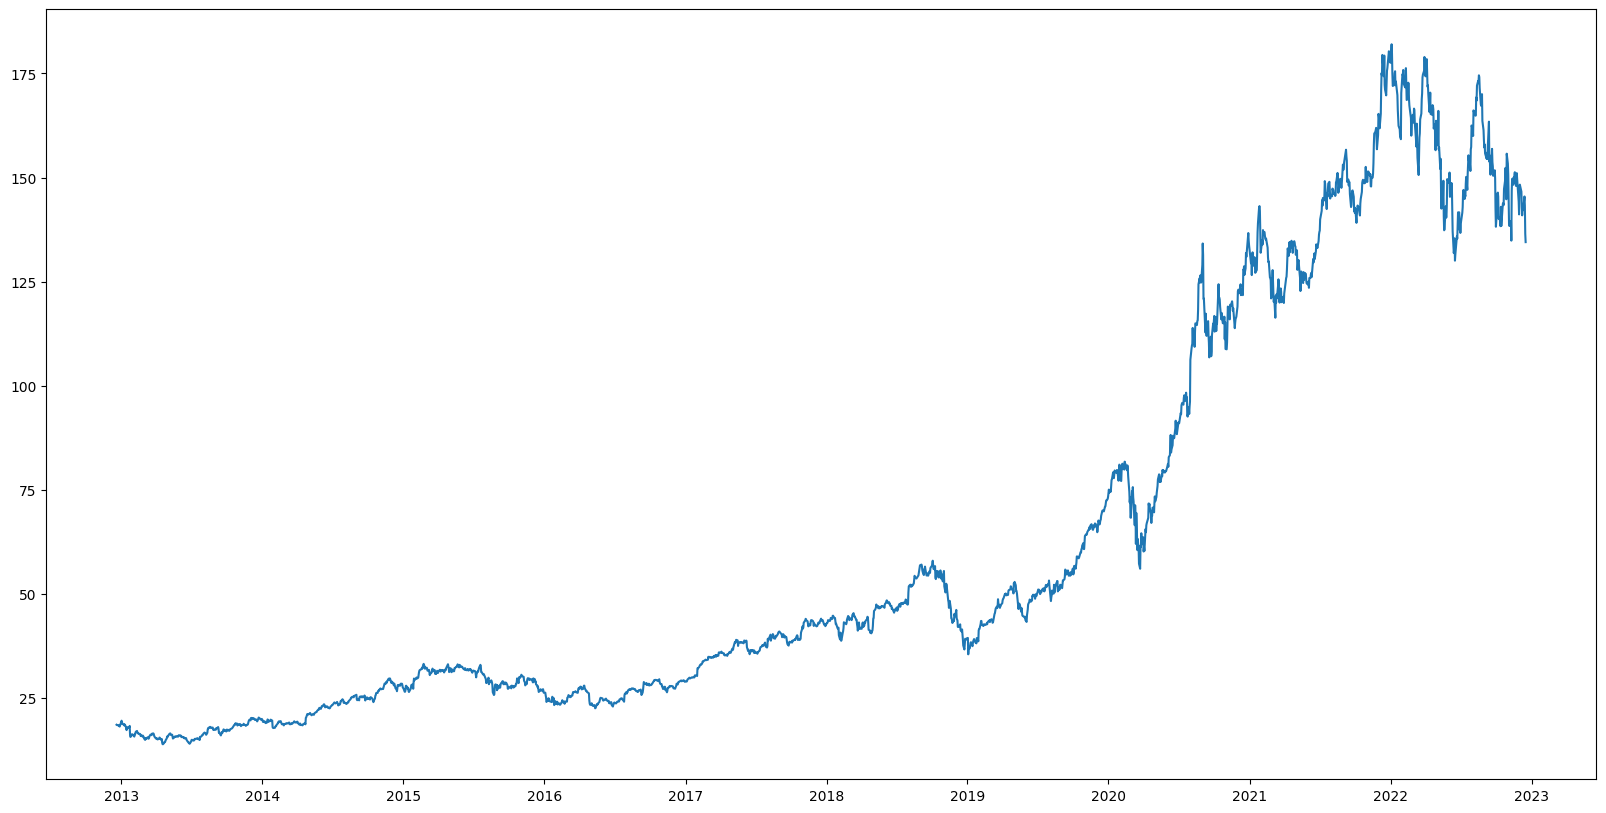

In [45]:
plt.plot(df["Close"],label='Close Price history')

# Long Short-Term Memory Prediction Model:

Data preparation:

In [46]:
df = df.sort_index(ascending=True,axis=0)

data = pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    data["Date"][i]=(df['Date'][i])
    data["Close"][i]=df["Close"][i]

data.head()

,Date,Close
0,2012-12-20 00:00:00,18.6332
1,2012-12-21 00:00:00,18.5475
2,2012-12-24 00:00:00,18.5774
3,2012-12-26 00:00:00,18.3214
4,2012-12-27 00:00:00,18.395


Min-Max Scaler:
(I use 80% as train data and 20% as test data)

In [47]:
data.index=data.Date

data.drop('Date',axis=1,inplace=True)

finalData = data.values

trainData=finalData[0:1964,:]
validData=finalData[1964:,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaledData=scaler.fit_transform(finalData)

xTrain,yTrain=[],[]


scaledData.shape[0]



2516

In [48]:
for i in range(60,scaledData.shape[0]):
    xTrain.append(scaledData[i-60:i,0])
    yTrain.append(scaledData[i,0])

Convert xTrain and yTrain to numpy arrays in order to train and test the model with the data:

In [49]:
xTrain,yTrain=np.array(xTrain),np.array(yTrain)
xTrain=np.reshape(xTrain,(xTrain.shape[0],xTrain.shape[1],1))

xTrain.shape

(2456, 60, 1)

Define LSTM Model:

In [50]:
lstm=Sequential()
lstm.add(LSTM(units=50,return_sequences=True,input_shape=(xTrain.shape[1],1)))
lstm.add(LSTM(units=50))
lstm.add(Dense(1))

print(lstm.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
None


Train & Test Data:

In [51]:
inputs_data=data[len(data)-len(validData)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

In [52]:
lstm.compile(loss='mean_squared_error',optimizer='adam')
lstm.fit(xTrain,yTrain,epochs=1,batch_size=1,verbose=2)

X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

2456/2456 - 38s - loss: 0.0016 - 38s/epoch - 15ms/step


Prediction:

In [53]:
closingPrice=lstm.predict(X_test)
closingPrice=scaler.inverse_transform(closingPrice)

18/18 [==============================] - 1s 8ms/step


# Prediction Result:

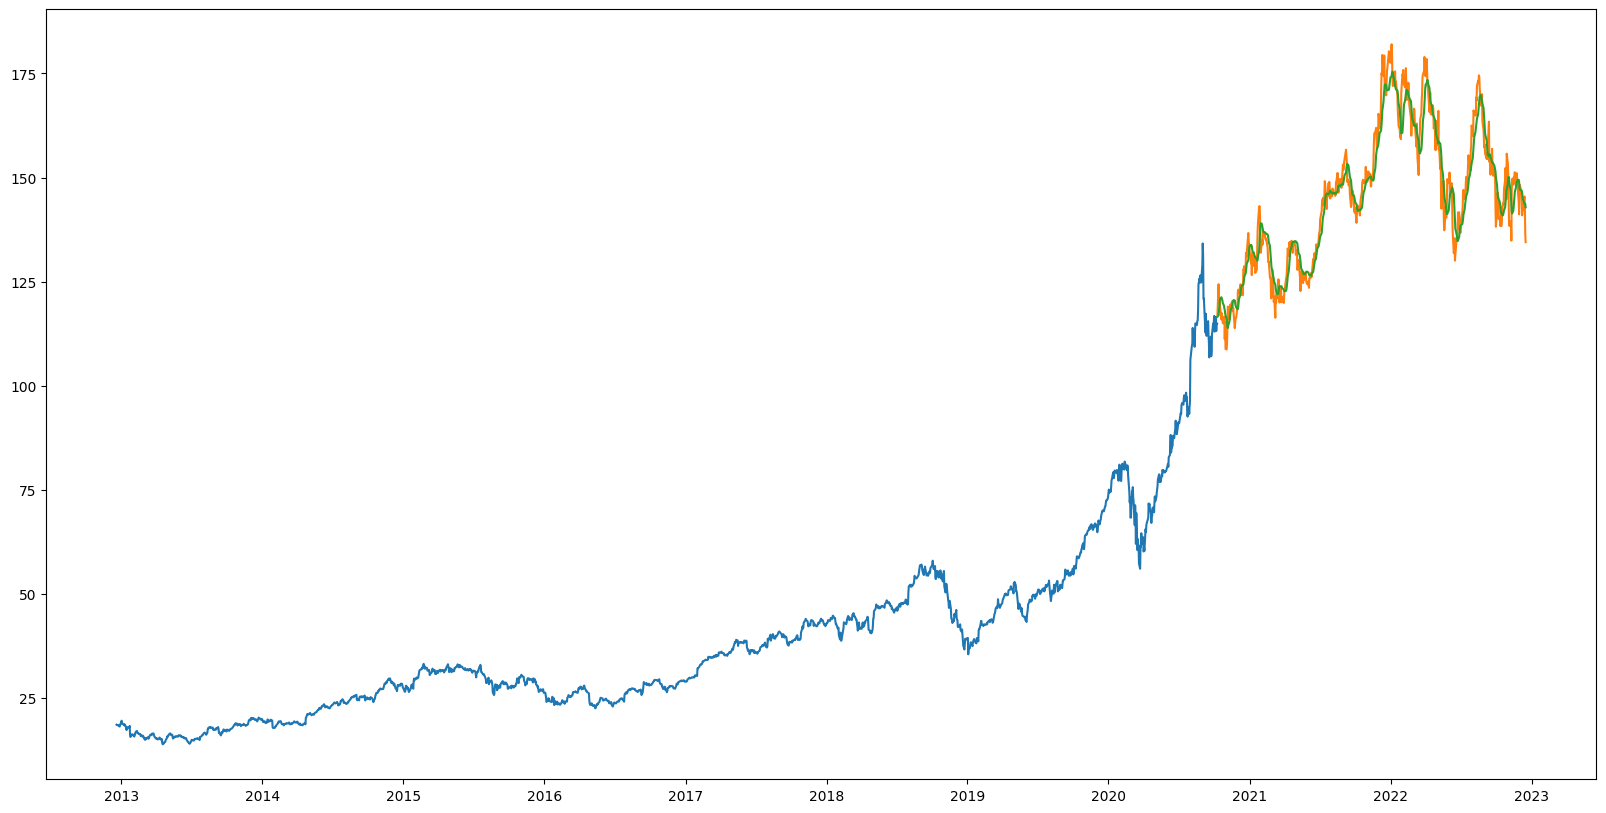

In [54]:
trainData=data[:1964]
validData=data[1964:].copy(deep=True)
validData['Predictions']=closingPrice
plt.plot(trainData["Close"])
plt.plot(validData[['Close',"Predictions"]])

Visualization: red color is the actual data, the green color is predicted